Download and setup the Spark environment

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apachemirror.wuchna.com/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz

In [8]:
!tar xf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install py4j

Setup the path variables

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/Data-Science-wih-Spark/movie-recommender/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init("spark-3.0.0-preview2-bin-hadoop2.7")# SPARK_HOME

Import libraries

In [0]:
from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import udf, col
import pyspark.sql.functions as F

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS #, Rating #, MatrixFactorizationModel

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [13]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(18, 4))

import seaborn as sns
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})

np.set_printoptions(precision=4, suppress=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# set random seed for reproducability
rnd_seed=42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [0]:
# The following must be set in your .bashrc file
#SPARK_HOME="/home/ubuntu/spark-2.4.0-bin-hadoop2.7"
#ANACONDA_HOME="/home/ubuntu/anaconda3/envs/pyspark"
#PYSPARK_PYTHON="$ANACONDA_HOME/bin/python"
#PYSPARK_DRIVER_PYTHON="$ANACONDA_HOME/bin/python"
#PYTHONPATH="$ANACONDA_HOME/bin/python"
#export PATH="$ANACONDA_HOME/bin:$SPARK_HOME/bin:$PATH"

Create session variables, and init Spark Context

In [16]:
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("movie-recommender-pyspark")
         .getOrCreate())
spark

In [17]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=movie-recommender-pyspark>

In [18]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

Show the default parallelism factor, and shows the default number of partitions if not specified

In [19]:
print (sc.defaultParallelism)

2


In [20]:
print(sc.getConf().toDebugString())

spark.app.id=local-1590582028619
spark.app.name=movie-recommender-pyspark
spark.driver.host=0262a70ef724
spark.driver.port=35093
spark.executor.id=driver
spark.master=local[*]
spark.rdd.compress=True
spark.serializer.objectStreamReset=100
spark.submit.deployMode=client
spark.submit.pyFiles=
spark.ui.showConsoleProgress=true


Setup database schema

In [0]:
ratings_schema = StructType([
    StructField("user_id", ShortType(), nullable=False),
    StructField("movie_id", ShortType(), nullable=False),
    StructField("rating", ByteType(), nullable=False),
    StructField("timestamp", LongType(), nullable=False)]
  )

In [24]:
# load the dataset
ratings_df = spark.read.csv("data/u.data", sep='\t', schema=ratings_schema)
ratings_df = ratings_df.drop('timestamp')
ratings_df.cache()
ratings_df.first()

DataFrame[user_id: smallint, movie_id: smallint, rating: tinyint]

Row(user_id=196, movie_id=242, rating=3)

In [25]:
ratings_df.limit(10).toPandas()

user_id  movie_id  rating
0      196       242       3
1      186       302       3
2       22       377       1
3      244        51       2
4      166       346       1
5      298       474       4
6      115       265       2
7      253       465       5
8      305       451       3
9        6        86       3

In [26]:
ratings_df.printSchema()

root
 |-- user_id: short (nullable = true)
 |-- movie_id: short (nullable = true)
 |-- rating: byte (nullable = true)



In [0]:
movies_schema = StructType([
    StructField("movie_id", ShortType(), nullable=True),
    StructField("title", StringType(), nullable=True),
    StructField("release_date", StringType(), nullable=False),
    StructField("video_release_date", StringType(), nullable=False),
    StructField("imdb_url", StringType(), nullable=False),
    StructField("unknown", ByteType(), nullable=False),
    StructField("action", ByteType(), nullable=False),
    StructField("adventure", ByteType(), nullable=False),
    StructField("animation", ByteType(), nullable=False),
    StructField("childrens", ByteType(), nullable=False),
    StructField("comedy", ByteType(), nullable=False),
    StructField("crime", ByteType(), nullable=False),
    StructField("documentary", ByteType(), nullable=False),
    StructField("drama", ByteType(), nullable=False),
    StructField("fantasy", ByteType(), nullable=False),
    StructField("filmnoir", ByteType(), nullable=False),
    StructField("horror", ByteType(), nullable=False),
    StructField("musical", ByteType(), nullable=False),
    StructField("mystery", ByteType(), nullable=False),
    StructField("romance", ByteType(), nullable=False),
    StructField("scifi", ByteType(), nullable=False),
    StructField("thriller", ByteType(), nullable=False),
    StructField("war", ByteType(), nullable=False),
    StructField("western", ByteType(), nullable=False)]
  )

In [0]:
movies_df = spark.read.csv("data/u.item", sep="|", schema=movies_schema).cache()

In [29]:
movies_df.limit(10).toPandas()

movie_id                                                 title  \
0         1                                      Toy Story (1995)   
1         2                                      GoldenEye (1995)   
2         3                                     Four Rooms (1995)   
3         4                                     Get Shorty (1995)   
4         5                                        Copycat (1995)   
5         6  Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)   
6         7                                 Twelve Monkeys (1995)   
7         8                                           Babe (1995)   
8         9                               Dead Man Walking (1995)   
9        10                                    Richard III (1995)   

  release_date video_release_date  \
0  01-Jan-1995               None   
1  01-Jan-1995               None   
2  01-Jan-1995               None   
3  01-Jan-1995               None   
4  01-Jan-1995               None   
5  01-Jan-1995               None   
6  01-Jan-1995               None   
7  01-Jan-1995               None   
8  01-Jan-1995               None   
9  22-Jan-1996               None   

                                                         imdb_url  unknown  \
0           http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)        0   
1             http://us.imdb.com/M/title-exact?GoldenEye%20(1995)        0   
2          http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)        0   
3          http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)        0   
4               http://us.imdb.com/M/title-exact?Copycat%20(1995)        0   
5    http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995)        0   
6      http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995)        0   
7                  http://us.imdb.com/M/title-exact?Babe%20(1995)        0   
8  http://us.imdb.com/M/title-exact?Dead%20Man%20Walking%20(1995)        0   
9         http://us.imdb.com/M/title-exact?Richard%20III%20(1995)        0   

   action  adventure  animation  childrens  comedy  crime  documentary  drama  \
0       0          0          1          1       1      0            0      0   
1       1          1          0          0       0      0            0      0   
2       0          0          0          0       0      0            0      0   
3       1          0          0          0       1      0            0      1   
4       0          0          0          0       0      1            0      1   
5       0          0          0          0       0      0            0      1   
6       0          0          0          0       0      0            0      1   
7       0          0          0          1       1      0            0      1   
8       0          0          0          0       0      0            0      1   
9       0          0          0          0       0      0            0      1   

   fantasy  filmnoir  horror  musical  mystery  romance  scifi  thriller  war  \
0        0         0       0        0        0        0      0         0    0   
1        0         0       0        0        0        0      0         1    0   
2        0         0       0        0        0        0      0         1    0   
3        0         0       0        0        0        0      0         0    0   
4        0         0       0        0        0        0      0         1    0   
5        0         0       0        0        0        0      0         0    0   
6        0         0       0        0        0        0      1         0    0   
7        0         0       0        0        0        0      0         0    0   
8        0         0       0        0        0        0      0         0    0   
9        0         0       0        0        0        0      0         0    1   

   western  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0

In [30]:
movies_df.printSchema()

root
 |-- movie_id: short (nullable = true)
 |-- title: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- video_release_date: string (nullable = true)
 |-- imdb_url: string (nullable = true)
 |-- unknown: byte (nullable = true)
 |-- action: byte (nullable = true)
 |-- adventure: byte (nullable = true)
 |-- animation: byte (nullable = true)
 |-- childrens: byte (nullable = true)
 |-- comedy: byte (nullable = true)
 |-- crime: byte (nullable = true)
 |-- documentary: byte (nullable = true)
 |-- drama: byte (nullable = true)
 |-- fantasy: byte (nullable = true)
 |-- filmnoir: byte (nullable = true)
 |-- horror: byte (nullable = true)
 |-- musical: byte (nullable = true)
 |-- mystery: byte (nullable = true)
 |-- romance: byte (nullable = true)
 |-- scifi: byte (nullable = true)
 |-- thriller: byte (nullable = true)
 |-- war: byte (nullable = true)
 |-- western: byte (nullable = true)



In [31]:
print("Number of partitions for the movies DataFrame: {0}".format(movies_df.rdd.getNumPartitions()))
print("Number of partitions for the ratings DataFrame: {0}".format(ratings_df.rdd.getNumPartitions()))

Number of partitions for the movies DataFrame: 1
Number of partitions for the ratings DataFrame: 1


In [32]:
ratings_df = ratings_df.repartition(10).cache()
movies_df = movies_df.repartition(10).cache()
print("Number of partitions for the movies DataFrame: {0}".format(movies_df.rdd.getNumPartitions()))
print("Number of partitions for the ratings DataFrame: {0}".format(ratings_df.rdd.getNumPartitions()))

Number of partitions for the movies DataFrame: 10
Number of partitions for the ratings DataFrame: 10


**Register the DataFrames as Temporary Views:**

In [0]:
movies_df.createOrReplaceTempView('movies')
ratings_df.createOrReplaceTempView('ratings')

Data Exploration

In [34]:
print("Number of different users: {0}".format(ratings_df.select('user_id').distinct().count()))

Number of different users: 943


In [35]:
print("Number of different movies: {0}".format(ratings_df.select('movie_id').distinct().count()))

Number of different movies: 1682


In [36]:
(print("Number of movies with at least one rating strictly higher than 4: {0}".format(ratings_df
                                                                                     .filter('rating > 4')
                                                                                     .select('movie_id')
                                                                                     .distinct()
                                                                                     .count())))

Number of movies with at least one rating strictly higher than 4: 1172


In [37]:
ratings_df.select(F.max('movie_id')).show()

+-------------+
|max(movie_id)|
+-------------+
|         1682|
+-------------+



In [38]:
ratings_df.select(F.max('user_id')).show()

+------------+
|max(user_id)|
+------------+
|         943|
+------------+



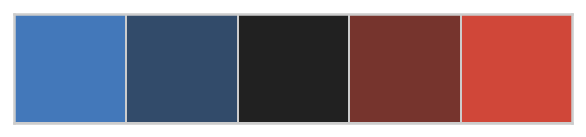

In [39]:
#sns.palplot(sns.diverging_palette(250, 15, n=5, center="dark"))

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


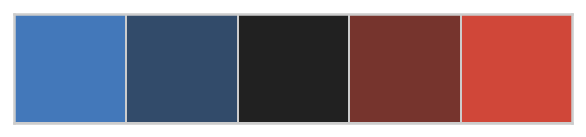

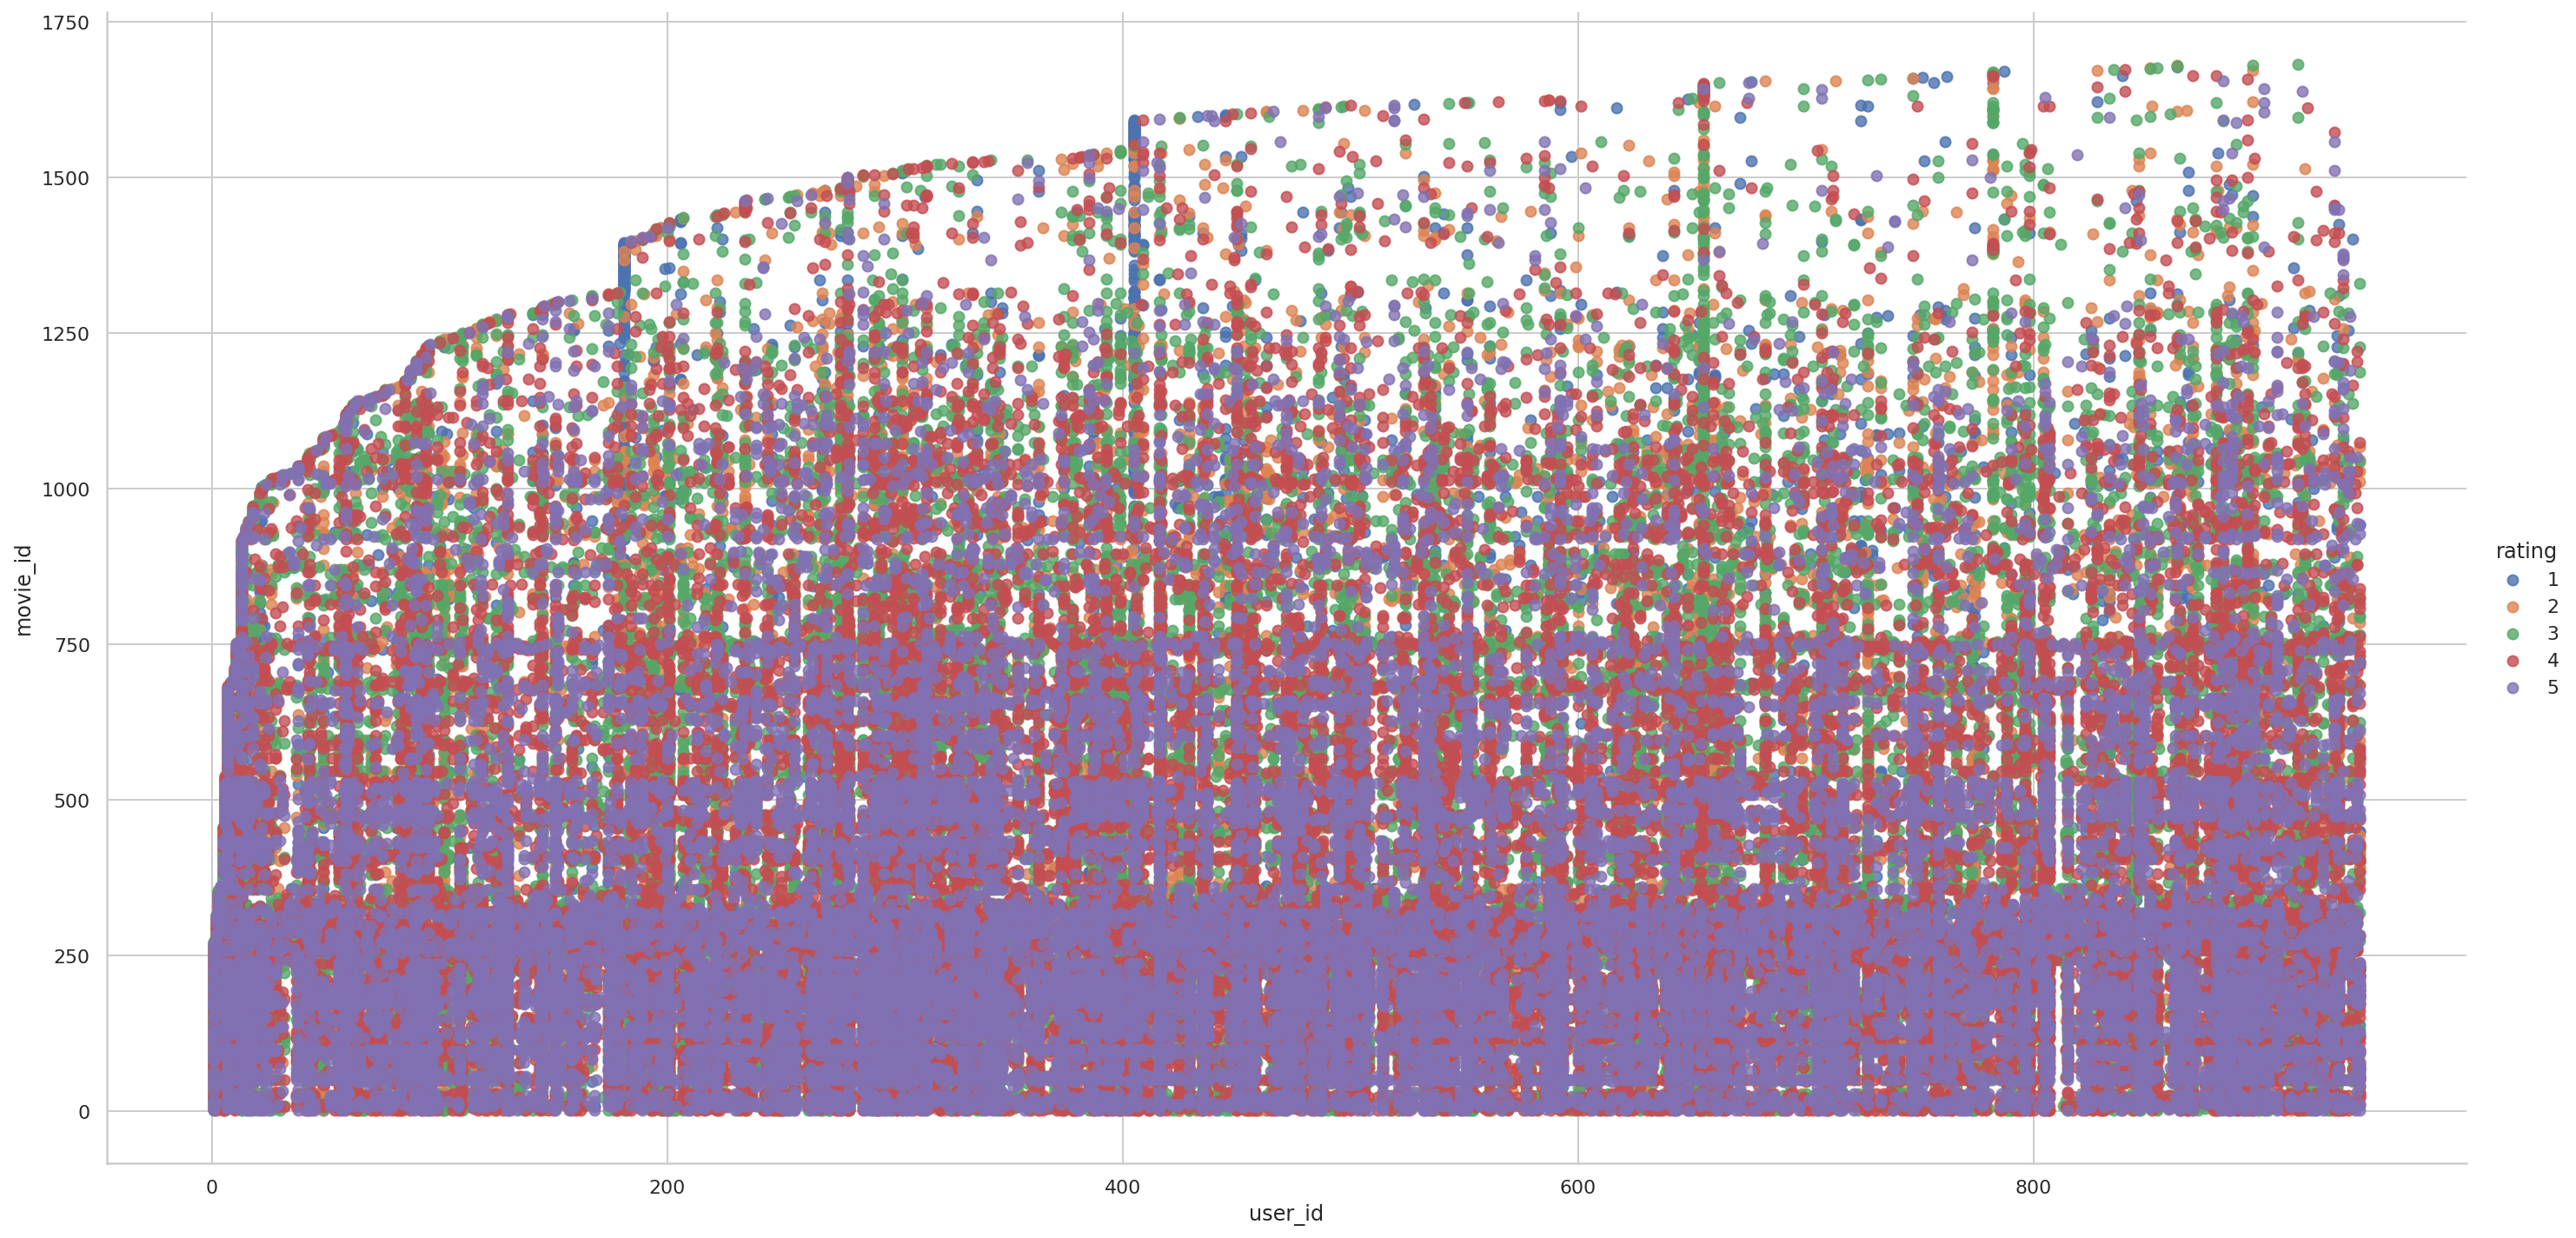

In [40]:
lm = (sns.lmplot(x='user_id', y='movie_id', hue='rating', 
                 data=ratings_df.toPandas(), 
                 fit_reg=False, size=10, aspect=2, 
                 palette=sns.palplot(sns.diverging_palette(250, 15, n=5, center="dark"))))
#axes = lm.axes
#axes[0,0].set_ylim(0,1682) # max movieId is 1682
#axes[0,0].set_xlim(0,943) # max userId is 943
#lm

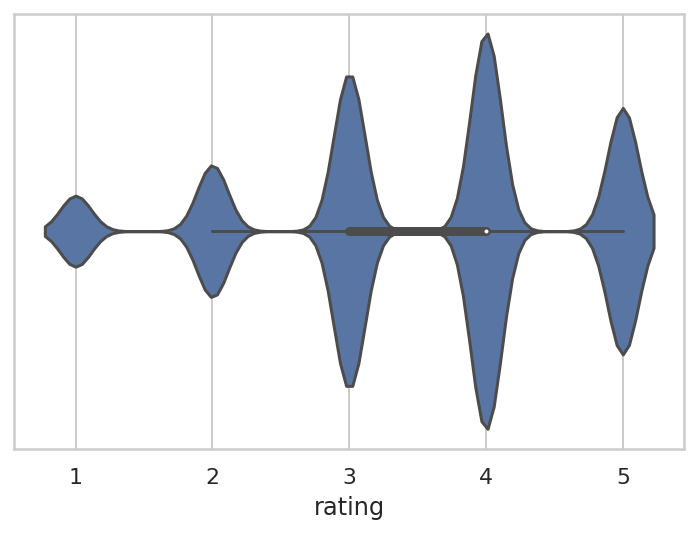

In [41]:
#sns.violinplot(ratings_df.toPandas()['rating']);

Text data preprocessing to remove space, etc.

In [0]:
import re

def strip_margin(text):
    nomargin = re.sub('\n[ \t]*\|', ' ', text)
    trimmed = re.sub('\s+', ' ', nomargin)
    return trimmed

Check the size of the ratings matrix:

In [43]:
spark.sql(strip_margin(
                    """SELECT *, 100 * nb_ratings/matrix_size AS percentage
                      |FROM (
                      |    SELECT nb_users, nb_movies, nb_ratings, nb_users * nb_movies AS matrix_size
                      |    FROM (
                      |        SELECT COUNT(*) AS nb_ratings, COUNT(DISTINCT(movie_id)) AS nb_movies, COUNT(DISTINCT(user_id)) AS nb_users
                      |        FROM ratings
                      |    )
                      |)
                    """)).show(truncate=False)

+--------+---------+----------+-----------+-----------------+
|nb_users|nb_movies|nb_ratings|matrix_size|percentage       |
+--------+---------+----------+-----------+-----------------+
|943     |1682     |100000    |1586126    |6.304669364224532|
+--------+---------+----------+-----------+-----------------+



Less than 6% of the matrix is filled.

To accurately evaluate the model, it's common practice in machine learning to split the data set between a training data set to train the model, and a test data set to compare the predicted results with the original results. This process is called cross-validation. Not doing cross-validation often leads to overfitting, which occurs when the model is too specific to the training data set and does not perform well on a more general data set. Here's the general iterative process of machine learning:

![](assets/machine-learning.png)

In [0]:
train_df, test_df = ratings_df.randomSplit([0.8, 0.2], seed=rnd_seed)

In [45]:
# we will cache the data because we will be using this dataframes over and over again
train_df.cache()
test_df.cache()

DataFrame[user_id: smallint, movie_id: smallint, rating: tinyint]

DataFrame[user_id: smallint, movie_id: smallint, rating: tinyint]

Use ALS for setting the recommender model, and fit the data to the model

In [0]:
# Build the recommendation model using ALS on the training data
als = ALS(rank=10, maxIter=10, regParam=0.01, userCol='user_id', itemCol='movie_id', ratingCol='rating', coldStartStrategy="drop", seed=rnd_seed)

In [0]:
model = als.fit(train_df)

**Latent Factors for the Users:**

In [48]:
# How many latent factors for users
model.userFactors.show(10, 100)

+---+----------------------------------------------------------------------------------------------------+
| id|                                                                                            features|
+---+----------------------------------------------------------------------------------------------------+
| 10|[-1.534542, -0.0512213, -0.018969959, -0.43308794, -0.017008537, -0.27971703, -0.55582684, 0.4466...|
| 20|[-1.3937428, -0.989416, 0.52360386, 0.078096285, 0.51509947, -0.7819915, 0.5767587, 0.73838556, -...|
| 30|[-1.4396801, -0.49521664, 0.1895786, 0.24151675, 0.22199921, 0.9631367, -0.6310639, 0.21549061, -...|
| 40|[-1.31187, -1.3771892, -0.3339359, -0.51992804, 0.028510643, -0.09519329, -0.7606984, -0.9722342,...|
| 50|[-1.7084789, 1.1894196, 0.8865464, 0.88206106, -0.812927, 0.9083932, 1.1472378, -0.16212858, -0.4...|
| 60|[-1.6839606, -0.04629807, -0.08687361, 0.016305283, 0.19397365, -0.119237125, -0.41263562, 0.2101...|
| 70|[-1.2817993, -0.42834064, -0.227

In [49]:
# How many users
model.userFactors.count()

943

**Latent Factors for the Movies:**

In [50]:
# How many latent factors for items
model.itemFactors.show(10, 100)

+---+----------------------------------------------------------------------------------------------------+
| id|                                                                                            features|
+---+----------------------------------------------------------------------------------------------------+
| 10|[-1.910456, 0.6683809, -0.5882778, -0.532406, -0.3484654, -0.32712552, -0.7699084, 0.8413057, -1....|
| 20|[-1.843135, -0.13500017, -0.5963153, 0.9104518, 1.1937597, -0.579014, -1.5506994, 0.39199698, -1....|
| 30|[-2.0216675, -0.17636319, -0.10442493, 0.28384778, 0.33155012, -0.459816, -1.5293479, 1.2579739, ...|
| 40|[-1.8440613, -0.659047, -0.5133588, -0.2315839, 0.2904805, -0.42574736, -0.0092899725, -0.0153207...|
| 50|[-2.4640355, -0.20255063, -0.8922208, 0.51239157, -0.25590333, 0.50089407, -0.34455407, 1.4622635...|
| 60|[-1.5678428, -0.32946515, -0.38012242, 0.46568745, 0.5934678, -0.34859353, -1.8754311, 0.52918756...|
| 70|[-1.9864571, -0.079296604, -0.06

In [51]:
# How many Movies
model.itemFactors.count()

1650

In [52]:
# How may Latent Factors?
model.rank

10

In [0]:
als = ALS(userCol="user_id", itemCol="movie_id", ratingCol="rating", coldStartStrategy="drop", seed=rnd_seed)

In [0]:
paramGrid = (ParamGridBuilder()
             .addGrid(als.rank, [1, 5, 10])
             .addGrid(als.maxIter, [20])
             .addGrid(als.regParam, [0.05, 0.1, 0.5])
             .build())

In [0]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='rating', metricName='rmse')

In [0]:
crossval = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

In [0]:
cvModel = crossval.fit(train_df)

In [0]:
best_model = cvModel.bestModel

In [59]:
test_df.sample(fraction=0.01).limit(10).show(10)

+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|     21|     445|     3|
|     83|    1043|     3|
|     87|       4|     5|
|     94|     800|     3|
|    122|     403|     4|
|    279|     810|     2|
|    286|      34|     5|
|    310|     181|     4|
|    332|      73|     4|
|    347|     410|     5|
+-------+--------+------+



In [0]:
movie_rating_preds = cvModel.transform(test_df)

In [61]:
movie_rating_preds.show(10)

+-------+--------+------+----------+
|user_id|movie_id|rating|prediction|
+-------+--------+------+----------+
|    332|     148|     5| 3.9253633|
|     44|     148|     4| 2.9908261|
|    916|     148|     2| 2.4491162|
|    236|     148|     4| 2.9914107|
|    222|     148|     2|  3.032292|
|    601|     148|     3|  1.959092|
|    727|     148|     2|   2.98579|
|    416|     148|     5| 3.7053556|
|    896|     148|     2| 2.3852792|
|    274|     148|     2| 3.5181751|
+-------+--------+------+----------+
only showing top 10 rows



**Check if any predictions are beyond the boundaries of 1.0 to 5.0:**

In [62]:
movie_rating_preds.filter("prediction < 1.0 or prediction > 5.0").show()

+-------+--------+------+----------+
|user_id|movie_id|rating|prediction|
+-------+--------+------+----------+
|    347|    1088|     1| 0.8899831|
|    387|     243|     1|  0.895597|
|    645|     243|     1|0.95542175|
|    489|     897|     2|0.89453053|
|    405|    1005|     1| 0.3894935|
|    279|     976|     3| 0.7179569|
|    405|     772|     1|0.40147316|
|    181|    1259|     1| 0.9391261|
|    868|    1031|     1|0.91807085|
|    774|    1274|     1| 0.8508696|
|    507|     300|     5| 5.3350744|
|    405|     784|     1|0.49837798|
|    472|      12|     5|  5.131913|
|    264|      12|     5|  5.207597|
|    152|      22|     5|  5.372414|
|    405|     556|     1| 0.9916142|
|    445|     325|     1| 0.9862262|
|    869|    1382|     3|0.74646974|
|    181|    1382|     1| 0.3944074|
|    782|    1382|     3| 0.5968922|
+-------+--------+------+----------+
only showing top 20 rows



**Clip predictions values between 1.0 to 5.0:**

In [0]:
movie_rating_preds = (movie_rating_preds
                      .withColumn("prediction", 
                                  F.when(col("prediction") > 5.0, 5.0)
                                  .when(col("prediction") < 1.0, 1.0)
                                  .otherwise(col("prediction")))
                     )

In [64]:
# recheck if there any any out of bound values
movie_rating_preds.filter("prediction < 1.0 or prediction > 5.0").show()

+-------+--------+------+----------+
|user_id|movie_id|rating|prediction|
+-------+--------+------+----------+
+-------+--------+------+----------+



In [65]:
movie_rating_preds.printSchema()

root
 |-- user_id: short (nullable = true)
 |-- movie_id: short (nullable = true)
 |-- rating: byte (nullable = true)
 |-- prediction: double (nullable = false)



In [66]:
movie_rating_preds = (movie_rating_preds
                      .withColumn("prediction_rounded", F.rint('prediction').cast(FloatType()))
                      .withColumn("rating", col('rating').cast(FloatType()))
                     )
movie_rating_preds.cache()

DataFrame[user_id: smallint, movie_id: smallint, rating: float, prediction: double, prediction_rounded: float]

In [67]:
movie_rating_preds.show(10)

+-------+--------+------+------------------+------------------+
|user_id|movie_id|rating|        prediction|prediction_rounded|
+-------+--------+------+------------------+------------------+
|    332|     148|   5.0| 3.925363302230835|               4.0|
|     44|     148|   4.0|  2.99082612991333|               3.0|
|    916|     148|   2.0|2.4491162300109863|               2.0|
|    236|     148|   4.0| 2.991410732269287|               3.0|
|    222|     148|   2.0| 3.032291889190674|               3.0|
|    601|     148|   3.0|1.9590920209884644|               2.0|
|    727|     148|   2.0|2.9857900142669678|               3.0|
|    416|     148|   5.0| 3.705355644226074|               4.0|
|    896|     148|   2.0|2.3852791786193848|               2.0|
|    274|     148|   2.0|3.5181751251220703|               4.0|
+-------+--------+------+------------------+------------------+
only showing top 10 rows



In [0]:
RMSE = evaluator.evaluate(movie_rating_preds)

In [69]:
print("Root Mean Squared Error = {0}".format(RMSE))

Root Mean Squared Error = 0.9125641050709978


In [70]:
# RMSE with rating rounded column
RegressionEvaluator(predictionCol='prediction_rounded', labelCol='rating', metricName='rmse').evaluate(movie_rating_preds)

0.9531902839286196

In [0]:
from pyspark.mllib.evaluation import RankingMetrics, RegressionMetrics

In [0]:
perUserActual = (movie_rating_preds
                 .where(col("rating") > 2.5)
                 .groupBy("user_id")
                 .agg(F.collect_set("movie_id").alias("movies")))

In [73]:
perUserActual.show()

+-------+--------------------+
|user_id|              movies|
+-------+--------------------+
|    833|[488, 1149, 357, ...|
|    496|[190, 561, 53, 89...|
|    463|[248, 306, 880, 8...|
|    148|[509, 204, 234, 3...|
|    471|[393, 50, 94, 878...|
|    737|[100, 169, 427, 1...|
|    623|[523, 204, 216, 5...|
|    897|[133, 510, 184, 4...|
|    392|[313, 270, 510, 3...|
|    540|[628, 147, 405, 2...|
|    243|[306, 387, 223, 1...|
|    858|               [307]|
|     31|[153, 493, 519, 4...|
|    516|[628, 660, 431, 5...|
|    580|[222, 147, 1, 249...|
|    137|[117, 680, 118, 5...|
|    451|[879, 292, 881, 3...|
|     85|[161, 284, 9, 132...|
|    251|[12, 281, 596, 1,...|
|    808|     [332, 751, 327]|
+-------+--------------------+
only showing top 20 rows



In [0]:
perUserPredictions = (movie_rating_preds
                 .orderBy(["user_id", "prediction"], ascending=[True, False])
                 .groupBy("user_id")
                 .agg(F.collect_set("movie_id").alias("movies")))

In [75]:
perUserPredictions.show()

+-------+--------------------+
|user_id|              movies|
+-------+--------------------+
|    148|[509, 204, 234, 3...|
|    463|[306, 887, 866, 1...|
|    471|[99, 393, 420, 62...|
|    496|[88, 190, 743, 56...|
|    833|[161, 488, 1149, ...|
|    243|[306, 208, 223, 1...|
|    392|[59, 270, 300, 51...|
|    540|[628, 147, 121, 4...|
|    623|[451, 204, 216, 5...|
|    737|[96, 100, 169, 32...|
|    858|          [307, 678]|
|    897|[133, 510, 184, 4...|
|     31|[153, 493, 519, 1...|
|    516|[628, 660, 431, 5...|
|     85|[258, 179, 425, 2...|
|    137|[117, 680, 118, 4...|
|    251|[12, 281, 476, 59...|
|    451|[879, 299, 988, 8...|
|    580|[222, 147, 1, 249...|
|    808|     [332, 751, 327]|
+-------+--------------------+
only showing top 20 rows



In [0]:
perUserActualvPred = (perUserActual.join(perUserPredictions, ["user_id"])
                      .rdd
                      .map(lambda row: (row[1], row[2][:15])))

In [0]:
ranks = RankingMetrics(perUserActualvPred)

In [78]:
ranks.meanAveragePrecision

0.8062777550225233

In [79]:
ranks.precisionAt(5)

0.8761497326203208

In [0]:
# top 3 movies recommended for each user
user_recs = best_model.recommendForAllUsers(3)

In [81]:
user_recs.show(truncate=False)

+-------+--------------------------------------------------------+
|user_id|recommendations                                         |
+-------+--------------------------------------------------------+
|471    |[[867, 6.3034625], [1410, 6.1341705], [1643, 5.99336]]  |
|463    |[[1176, 4.4385786], [1242, 4.402875], [884, 4.382208]]  |
|833    |[[1368, 5.1586175], [853, 4.6866593], [320, 4.684379]]  |
|496    |[[1368, 4.96786], [913, 4.667834], [884, 4.556062]]     |
|148    |[[1643, 5.704472], [169, 4.83857], [867, 4.830703]]     |
|540    |[[1643, 5.146909], [1169, 5.054273], [1449, 5.0010576]] |
|392    |[[1449, 5.161253], [1643, 5.0564933], [1398, 4.947053]] |
|243    |[[1643, 4.9235272], [1449, 4.690566], [793, 4.6002245]] |
|623    |[[1643, 5.2354684], [814, 4.6073713], [1599, 4.534316]] |
|737    |[[884, 5.4815784], [838, 5.3116007], [913, 5.277357]]   |
|897    |[[1427, 5.326589], [1169, 5.2771463], [1467, 5.112923]] |
|858    |[[838, 5.0609007], [1176, 5.0420775], [1664, 4.926787

In [82]:
# python trick to display data types inside the dataframe
user_recs

DataFrame[user_id: int, recommendations: array<struct<movie_id:int,rating:float>>]

**Reshape the movie_id and rating arrays into columns for an user:**

In [0]:
user_recs_one = user_recs.where(user_recs.user_id == 1).cache()

In [84]:
user_recs_one

DataFrame[user_id: int, recommendations: array<struct<movie_id:int,rating:float>>]

In [85]:
user_recs_one.show(truncate=False)

+-------+--------------------------------------------------------+
|user_id|recommendations                                         |
+-------+--------------------------------------------------------+
|1      |[[1643, 5.6624703], [1449, 5.0671134], [1398, 4.981974]]|
+-------+--------------------------------------------------------+



In [86]:
user_recs_one.select("user_id", "recommendations.movie_id", "recommendations.rating").collect()

[Row(user_id=1, movie_id=[1643, 1449, 1398], rating=[5.66247034072876, 5.067113399505615, 4.981974124908447])]

In [87]:
user_recs_one.select("user_id", "recommendations.movie_id", "recommendations.rating").show()

+-------+------------------+--------------------+
|user_id|          movie_id|              rating|
+-------+------------------+--------------------+
|      1|[1643, 1449, 1398]|[5.6624703, 5.067...|
+-------+------------------+--------------------+



**Reshape using a Sequence Id (Join Using monotonically_increasing_id()):**

In order to join the recommended movies and recommended ratings we need to introduce an additional id column. In order to ensure that the values in the id column is increasing we use the monotonically_increasing_id() function. This function is guaranteed to produce increasing numbers but not guaranteed to produce sequential increasing numbers if there are more than 1 partition in the dataframe. So we also repartition the exploded dataframe into 1 partition.

In [88]:
only_movies = user_recs_one.select("user_id", F.explode(col("recommendations.movie_id")).alias("movie_id"))
only_movies = only_movies.repartition(1).withColumn('id', F.monotonically_increasing_id())
only_movies = only_movies.select('id', 'user_id', 'movie_id')
only_movies.show()

+---+-------+--------+
| id|user_id|movie_id|
+---+-------+--------+
|  0|      1|    1643|
|  1|      1|    1449|
|  2|      1|    1398|
+---+-------+--------+



In [89]:
only_ratings = user_recs_one.select("user_id", F.explode(col("recommendations.rating")).alias("rating"))
only_ratings = only_ratings.repartition(1).withColumn('id', F.monotonically_increasing_id())
only_ratings = only_ratings.select('id', 'user_id', 'rating')
only_ratings.show()

+---+-------+---------+
| id|user_id|   rating|
+---+-------+---------+
|  0|      1|5.6624703|
|  1|      1|5.0671134|
|  2|      1| 4.981974|
+---+-------+---------+



In [90]:
only_movies.join(only_ratings.drop('user_id'), on='id', how='inner').drop('id').show()

+-------+--------+---------+
|user_id|movie_id|   rating|
+-------+--------+---------+
|      1|    1643|5.6624703|
|      1|    1449|5.0671134|
|      1|    1398| 4.981974|
+-------+--------+---------+



**Reshape without using a Sequence Id:**

We can do the same thing as above even without using a id column. All we need to do is to explode the struct column and then select the sub fields of the struct column.

In [91]:
(user_recs_one
 .select("user_id", F.explode("recommendations").alias("reco"))).show()

+-------+-----------------+
|user_id|             reco|
+-------+-----------------+
|      1|[1643, 5.6624703]|
|      1|[1449, 5.0671134]|
|      1| [1398, 4.981974]|
+-------+-----------------+



Although, the explode("recommendations") is now generated as "reco" we can still access subfields of that struct column. This information is hiddent inside the column metadata.

In [92]:
(user_recs_one
 .select("user_id", F.explode("recommendations").alias("reco"))
 .select("user_id", "reco.movie_id", "reco.rating")).show()

+-------+--------+---------+
|user_id|movie_id|   rating|
+-------+--------+---------+
|      1|    1643|5.6624703|
|      1|    1449|5.0671134|
|      1|    1398| 4.981974|
+-------+--------+---------+



In [93]:
user_recs_one.unpersist()

DataFrame[user_id: int, recommendations: array<struct<movie_id:int,rating:float>>]

**Filter out the user we are interested from the set of all predictions:**

In [94]:
user_recs.where(user_recs.user_id == 2).show(truncate=False)

+-------+-----------------------------------------------------+
|user_id|recommendations                                      |
+-------+-----------------------------------------------------+
|2      |[[1449, 4.8591895], [127, 4.717512], [1242, 4.68608]]|
+-------+-----------------------------------------------------+



**Create a subset user dataframe and invoke `recommendForUserSubset` on the model:**

In [0]:
user_subset = ratings_df.where(ratings_df.user_id == 2)

In [96]:
user_subset.show()

+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|      2|     237|     4|
|      2|     316|     5|
|      2|     100|     5|
|      2|     286|     4|
|      2|     274|     3|
|      2|      19|     3|
|      2|     294|     1|
|      2|     306|     4|
|      2|     308|     3|
|      2|     293|     4|
|      2|      25|     4|
|      2|     307|     3|
|      2|     275|     5|
|      2|     290|     3|
|      2|     298|     3|
|      2|     276|     4|
|      2|     283|     5|
|      2|     300|     4|
|      2|      14|     4|
|      2|     296|     3|
+-------+--------+------+
only showing top 20 rows



In [0]:
user_subset_recs = best_model.recommendForUserSubset(user_subset, 3)

In [98]:
user_subset_recs.show(truncate=False)

+-------+-----------------------------------------------------+
|user_id|recommendations                                      |
+-------+-----------------------------------------------------+
|2      |[[1449, 4.8591895], [127, 4.717512], [1242, 4.68608]]|
+-------+-----------------------------------------------------+



In [99]:
(user_subset_recs
 .select("user_id", F.explode("recommendations").alias("reco"))
 .select("user_id", "reco.movie_id", "reco.rating")).show()

+-------+--------+---------+
|user_id|movie_id|   rating|
+-------+--------+---------+
|      2|    1449|4.8591895|
|      2|     127| 4.717512|
|      2|    1242|  4.68608|
+-------+--------+---------+



In [0]:
# top 3 users recommended for each movie, for all movies.
movie_recs = best_model.recommendForAllItems(3)

In [101]:
movie_recs.show(truncate=False)

+--------+-----------------------------------------------------+
|movie_id|recommendations                                      |
+--------+-----------------------------------------------------+
|1580    |[[362, 1.2409755], [36, 1.1795373], [562, 1.1724148]]|
|471     |[[688, 5.243927], [507, 4.936607], [849, 4.9117227]] |
|1591    |[[440, 5.020911], [519, 4.918273], [414, 4.3268194]] |
|1342    |[[688, 2.4654014], [507, 2.359329], [38, 2.2569249]] |
|463     |[[688, 5.035219], [173, 4.787966], [295, 4.7382693]] |
|833     |[[636, 4.376279], [472, 4.3158064], [4, 4.304065]]   |
|496     |[[688, 5.9979143], [810, 5.383911], [909, 5.328819]] |
|148     |[[688, 5.2054257], [507, 5.1248684], [38, 4.964296]] |
|1088    |[[471, 4.8170753], [507, 3.787861], [38, 3.748219]]  |
|1238    |[[427, 4.8801184], [519, 4.830583], [36, 4.7313423]] |
|540     |[[688, 4.106073], [507, 3.6890743], [38, 3.661489]]  |
|1460    |[[688, 4.165653], [808, 3.8723843], [909, 3.8673398]]|
|392     |[[507, 5.298114

**Filter out the movie we are interested from the set of all predictions:**

In [0]:
movie_recs_one = movie_recs.where(movie_recs.movie_id == 36).cache()

In [103]:
movie_recs_one.show(truncate=False)

+--------+-----------------------------------------------------+
|movie_id|recommendations                                      |
+--------+-----------------------------------------------------+
|36      |[[180, 3.6362457], [531, 3.578546], [212, 3.5126326]]|
+--------+-----------------------------------------------------+



In [104]:
movie_recs_one.select("recommendations.user_id", "recommendations.rating").collect()

[Row(user_id=[180, 531, 212], rating=[3.6362457275390625, 3.5785460472106934, 3.5126326084136963])]

**Create a subset movie dataframe and invoke `recommendForItemSubset` on the model:**

In [0]:
movie_subset = ratings_df.where(ratings_df.movie_id == 36)

In [106]:
movie_subset.show()

+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|    256|      36|     3|
|    201|      36|     1|
|    796|      36|     1|
|    477|      36|     4|
|    293|      36|     1|
|    393|      36|     3|
|    314|      36|     2|
|    405|      36|     2|
|      1|      36|     2|
|    846|      36|     2|
|    655|      36|     2|
|    184|      36|     3|
|    416|      36|     2|
+-------+--------+------+



In [0]:
movie_subset_recs = best_model.recommendForItemSubset(movie_subset, 3)

In [108]:
movie_subset_recs.select("movie_id", "recommendations.user_id", "recommendations.rating").show(truncate=False)

+--------+---------------+--------------------------------+
|movie_id|user_id        |rating                          |
+--------+---------------+--------------------------------+
|36      |[180, 531, 212]|[3.6362457, 3.578546, 3.5126326]|
+--------+---------------+--------------------------------+



In [109]:
(movie_subset_recs
 .select("movie_id", F.explode("recommendations").alias("reco"))
 .select("movie_id", "reco.user_id", "reco.rating")).show()

+--------+-------+---------+
|movie_id|user_id|   rating|
+--------+-------+---------+
|      36|    180|3.6362457|
|      36|    531| 3.578546|
|      36|    212|3.5126326|
+--------+-------+---------+



In [0]:
from pyspark.sql import Row
test_user_movie_df = spark.createDataFrame([Row(user_id=789, movie_id=123)], ['user_id', 'movie_id'])

In [111]:
test_user_movie_df.show()

+-------+--------+
|user_id|movie_id|
+-------+--------+
|    123|     789|
+-------+--------+



**Predict Rating:**

In [112]:
best_model.transform(test_user_movie_df).show()

+-------+--------+----------+
|user_id|movie_id|prediction|
+-------+--------+----------+
|    123|     789| 3.4480674|
+-------+--------+----------+



In [0]:
from pyspark.sql import Row
test_user_df = spark.createDataFrame([Row(user_id=789)], ['user_id'])

In [114]:
test_user_df.show()

+-------+
|user_id|
+-------+
|    789|
+-------+



In [0]:
test_user_recs = best_model.recommendForUserSubset(test_user_df, 10).cache()

In [116]:
test_user_recs.select("user_id", "recommendations.movie_id", "recommendations.rating").show()

+-------+--------------------+--------------------+
|user_id|            movie_id|              rating|
+-------+--------------------+--------------------+
|    789|[1368, 1589, 1643...|[5.5287147, 5.197...|
+-------+--------------------+--------------------+



In [117]:
(test_user_recs
 .select("user_id", F.explode("recommendations").alias("reco"))
 .select("user_id", "reco.movie_id", "reco.rating")).show()

+-------+--------+---------+
|user_id|movie_id|   rating|
+-------+--------+---------+
|    789|    1368|5.5287147|
|    789|    1589|5.1973715|
|    789|    1643|5.1588287|
|    789|    1592| 5.019322|
|    789|    1467|4.9397883|
|    789|     320| 4.815704|
|    789|    1656|4.8120527|
|    789|     119| 4.794572|
|    789|    1495|4.7921643|
|    789|    1585|4.7875733|
+-------+--------+---------+



**Combine genre information with the recommendations:**

In [0]:
movie_genres = (['unknown', 'action', 'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 
                 'fantasy', 'filmnoir', 'horror', 'musical', 'mystery', 'romance', 'scifi', 'thriller', 'war', 'western'])

In [0]:
# An utility function to combine all active genres of the movie into an array
from numpy import ma
def combine_genres(genres):
    x = ma.masked_array(movie_genres, mask=(1 - np.array(genres)))
    return x[~x.mask].data.tolist()

In [120]:
combine_genres([0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0])

['adventure', 'comedy', 'documentary', 'fantasy', 'mystery', 'scifi', 'war']

In [0]:
udf_combine_genres = udf(lambda genres: combine_genres(genres), ArrayType(elementType=StringType()))

**Retrieve top 10 Movies predicted for User 789:**

In [122]:
print('Recommended Top 10 Movies For User 789:')
(test_user_recs
 .select('user_id', F.explode(col("recommendations")).alias("reco"))
 .select("user_id", "reco.movie_id", "reco.rating")
 .join(movies_df, on=['movie_id'], how='inner')
 .withColumn('genres', udf_combine_genres(F.array('unknown', 'action', 'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmnoir', 'horror', 'musical', 'mystery', 'romance', 'scifi', 'thriller', 'war', 'western')))
 .select('user_id', 'movie_id', F.round('rating', 0).alias('rating'), 'title', 'genres')
 .orderBy(F.desc('rating'), 'movie_id')
).show(truncate=False)

Recommended Top 10 Movies For User 789:
+-------+--------+------+-----------------------------------------------------------+-----------------+
|user_id|movie_id|rating|title                                                      |genres           |
+-------+--------+------+-----------------------------------------------------------+-----------------+
|789    |1368    |6.0   |Mina Tannenbaum (1994)                                     |[drama]          |
|789    |119     |5.0   |Maya Lin: A Strong Clear Vision (1994)                     |[documentary]    |
|789    |320     |5.0   |Paradise Lost: The Child Murders at Robin Hood Hills (1996)|[documentary]    |
|789    |1467    |5.0   |Saint of Fort Washington, The (1993)                       |[drama]          |
|789    |1495    |5.0   |Flirt (1995)                                               |[drama]          |
|789    |1585    |5.0   |American Dream (1990)                                      |[documentary]    |
|789    |1589    |5.0   

**Retrieve top 10 Movies rated by User 789:**

In [123]:
sqlContext.udf.register("sql_udf_combine_genres", combine_genres, ArrayType(elementType=StringType()))

<function __main__.combine_genres>

In [124]:
# Top 10 movies rated by user 789
print('Top 10 Rated Movies by User 789:')
spark.sql(strip_margin(
                    """SELECT r.user_id, r.movie_id, cast(r.rating as float), m.title, sql_udf_combine_genres(array(unknown, action, adventure, animation, childrens, comedy, crime, documentary, drama, fantasy, filmnoir, horror, musical, mystery, romance, scifi, thriller, war, western)) as genres
                      |FROM ratings r, movies m
                      |WHERE r.user_id = 789
                      |AND r.movie_id = m.movie_id
                      |ORDER BY r.rating DESC, r.movie_id 
                      |LIMIT 10
                    """)).show(truncate=False)

Top 10 Rated Movies by User 789:
+-------+--------+------+-------------------------------+----------------------------------------+
|user_id|movie_id|rating|title                          |genres                                  |
+-------+--------+------+-------------------------------+----------------------------------------+
|789    |9       |5.0   |Dead Man Walking (1995)        |[drama]                                 |
|789    |50      |5.0   |Star Wars (1977)               |[action, adventure, romance, scifi, war]|
|789    |100     |5.0   |Fargo (1996)                   |[crime, drama, thriller]                |
|789    |127     |5.0   |Godfather, The (1972)          |[action, crime, drama]                  |
|789    |129     |5.0   |Bound (1996)                   |[crime, drama, romance, thriller]       |
|789    |150     |5.0   |Swingers (1996)                |[comedy, drama]                         |
|789    |276     |5.0   |Leaving Las Vegas (1995)       |[drama, romance]   

Comparing the Recommendations with the Movies that the user already Rated with high rating it appears he likes movies around 1995 time frame and of genre Drama. He also likes movies of genre romance and thriller but they are not recommended.

In [0]:
spark.stop()